In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install japanize_matplotlib

     |████████████████████████████████| 4.1 MB 5.4 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=83d6b84e69f2432c34000042f74d21b0552485d9a6bb6aa748f6c037d43a8850
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [ ]:
## import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib_venn import venn2
import os

import missingno as msno

from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing
from time import time
from contextlib import contextmanager
import lightgbm as lgb
import scipy.stats as st

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [ ]:
input_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/data/"
output_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/output/"

pd.set_option("display.max_colwidth", 50)

# Import file
df1 = pd.read_csv(input_dir + "gi_train_mm10.csv")
df2 = pd.read_csv(input_dir + "gi_train_mm11.csv")
df_test = pd.read_csv(input_dir + "gi_test.csv")
item_area =pd.read_csv(output_dir + "item_df.csv",index_col=0)
sample_submit = pd.read_csv(input_dir + "gi_sample_submit.csv")
df_train = pd.concat([df1,df2]).reset_index(drop=True)
df_train = df_train[~df_train.customer_id.isnull()].reset_index()

In [ ]:
df_train = df_train[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch', 
                     'in_time',
                     'out_time', 
                     'buy_flag']]

df_test = df_test[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch',
                     'in_time',
                     'out_time']]

In [ ]:
train_org = df_train
train_test = df_test

In [ ]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

In [ ]:
#shopper属性
df_shopper_train=df_train[["customer_id","gender","age","age_category"]].drop_duplicates().set_index("customer_id")
df_shopper_test=df_test[["customer_id","gender","age","age_category"]].drop_duplicates().set_index("customer_id")

#shopper接触回数（合計）
df_contact_train = df_train.groupby("customer_id")[["num_touch"]].sum().astype(int)
df_contact_test = df_test.groupby("customer_id")[["num_touch"]].sum().astype(int)

#shopper area id
df_area_train=pd.crosstab(df_train2.customer_id,df_train2.area_id).fillna(0).astype(int)
df_area_train.columns=["area_1","area_2","area_3","area_4","area_5"]
df_area_test=pd.crosstab(df_test2.customer_id,df_test2.area_id).fillna(0).astype(int)
df_area_test.columns=["area_1","area_2","area_3","area_4","area_5"]

#shpper area time
df_areatime_train=pd.pivot_table(df_train2,index="customer_id",columns="area_id",values="time_duration").fillna(0)
df_areatime_train.columns=["area_time_1","area_time_2","area_time_3","area_time_4","area_time_5"]
df_areatime_test=pd.pivot_table(df_test2,index="customer_id",columns="area_id",values="time_duration").fillna(0)
df_areatime_test.columns=["area_time_1","area_time_2","area_time_3","area_time_4","area_time_5"]

#shopper frame time
df_frametime_train=df_train1[["customer_id","time_duration","in_time"]].drop_duplicates().set_index("customer_id")
df_frametime_test=df_test1[["customer_id","time_duration","in_time"]].drop_duplicates().set_index("customer_id")

#shopper_touch_items
df_touch_item_train=df_train[df_train.num_touch > 0][["customer_id","product_name","product_id","company"]]
df_touch_item_train=pd.crosstab(df_touch_item_train.customer_id,df_touch_item_train.product_name).astype(int)
df_touch_item_test=df_test[df_test.num_touch > 0][["customer_id","product_name","product_id","company"]]
df_touch_item_test=pd.crosstab(df_touch_item_test.customer_id,df_touch_item_test.product_name).astype(int)

#shopper_touch_items_company
df_touch_item_comp_train=df_train[df_train.num_touch > 0][["customer_id","product_name","product_id","company"]]
df_touch_item_comp_train=pd.crosstab(df_touch_item_comp_train.customer_id,df_touch_item_comp_train.company).astype(int)
df_touch_item_comp_test=df_test[df_test.num_touch > 0][["customer_id","product_name","product_id","company"]]
df_touch_item_comp_test=pd.crosstab(df_touch_item_comp_test.customer_id,df_touch_item_comp_test.company).astype(int)

#shopper購入回数(合計）
df_buy_train = df_train3.groupby("customer_id")[["buy_flag"]].sum().astype(int)


#接触アイテム種類カウント
df_touch_item_train_2 = df_touch_item_train.copy()
df_touch_item_test_2 = df_touch_item_test.copy()

def replace_one(x):
  if x >=1:
    x=1
    return x
  else:
    x=0
    return x

for column in df_touch_item_train.columns:
  df_touch_item_train_2[column] = df_touch_item_train[column].apply(lambda x:replace_one(x)) 

df_touch_item_train_2["item_count"]=df_touch_item_train_2.sum(axis=1)
df_touch_item_train_2 = df_touch_item_train_2[["item_count"]]

for column in df_touch_item_test.columns:
  df_touch_item_test_2[column] = df_touch_item_test[column].apply(lambda x:replace_one(x)) 

df_touch_item_test_2["item_count"]=df_touch_item_test_2.sum(axis=1)
df_touch_item_test_2 = df_touch_item_test_2[["item_count"]]

In [ ]:
df_train = pd.concat([df_shopper_train, 
                      df_contact_train,
                      df_area_train,
                      df_areatime_train,
                      df_frametime_train,
                      df_touch_item_train,
                      df_touch_item_train_2,
                      df_touch_item_comp_train,
                      df_buy_train],
                      axis=1)

df_train = df_train.fillna(0).reset_index()

df_test = pd.concat([df_shopper_test, 
                      df_contact_test,
                      df_area_test,
                      df_areatime_test,
                      df_frametime_test,
                      df_touch_item_test,
                      df_touch_item_test_2,
                      df_touch_item_comp_test],
                      axis=1)

df_test = df_test.fillna(0).reset_index()


In [ ]:
df_train["area_total"]= df_train.area_1.values+df_train.area_2.values+df_train.area_3.values+df_train.area_4.values+df_train.area_5.values
df_test["area_total"]= df_test.area_1.values+df_test.area_2.values+df_test.area_3.values+df_test.area_4.values+df_test.area_5.values

In [ ]:
df_train["in_time"] = pd.to_datetime(df_train["in_time"])
df_train["in_time"] = df_train["in_time"].apply(lambda x: x.hour)

In [ ]:
df_train.index = df_train["index"]
df_train = df_train.iloc[:,1:]

In [ ]:
df_train

,gender,age,age_category,num_touch,area_1,area_2,area_3,area_4,area_5,area_time_1,area_time_2,area_time_3,area_time_4,area_time_5,time_duration,in_time,3時のオレ500ml,Cウォーター500ml,あなたのソーダ500ml,あの日のソーダ500ml,うつくし檸檬水500ml,うるうるグリーンティー525ml,おいしい新茶470ml,おいしい時間555ml,おそば屋さんのお茶500ml,かろやかアップル425ml,かろやかオレンジ425ml,きよらかなリンゴ水430ml,こだわりコーヒー無糖500ml,こゆいオレ500ml,ごくごくスポドリ500ml,しゅわしゅわオレンジ420ml,しゅわしゅわプルーン500ml,しゅわしゅわミックスベリー500ml,しゅわしゅわ檸檬ライム470ml,しゅわっとれもん450ml,すっぱいかんきつドリンク400ml,ちょこっとファイバー100ml,つぶつぶミカンジュース400ml,つよーい炭酸水490ml,...,河のせせらぎ500ml,激熱苺480ml,無農薬健康茶600ml,燃えろイナヅマ600ml,燕ブランドのローストグリーンティー525ml,爆発GP480ml,玄米のおいしいお茶500ml,玉露水525ml,職人の力500ml,花の癒し500ml,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml,item_count,かのうハウス,せかいのごはん,イッツ園,エターナル,オールフロント,カルシウムウェイ,クオリティー,ゲーミングファイト,デイリーイースト,トップモード,ネイティブ,フューチャー,モーリーフラフト,ラボラトリー,レジェンド,レモン王,大自然カンパニー,青牛,buy_flag,area_total
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20201026-010001,woman,30's,Young,2,1.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,0.0,0.0,6.2,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
20201026-010002,man,50's,Middle,2,1.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,13.6,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
20201026-010003,man,50's,Middle,3,1.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,14.2,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
20201026-010004,man,10's,Teen,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20201026-010005,woman,30's,Young,1,1.0,0.0,0.0,0.0,0.0,4.8,0.0,0.0,0.0,0.0,19.2,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201101-120050,man,30's,Young,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.4,16.4,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
20201101-120053,man,30's,Young,11,1.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,42.2,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0
20201101-120054,man,30's,Young,3,1.0,0.0,0.0,0.0,0.0,11.2,0.0,0.0,0.0,0.0,28.4,21,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
df_train[df_train.buy_flag >=1].item_count.value_counts()

1.0     2050
2.0      629
3.0      207
4.0       76
5.0       34
6.0       10
8.0        6
7.0        5
10.0       2
9.0        1
11.0       1
Name: item_count, dtype: int64

## 全体区分け

In [ ]:
all =len(df_train)

#エリア素通り
client_0 = df_train[(df_train.num_touch ==0) & (df_train.area_total==0)]
a = len(client_0)

#購入商品決定
client_1 = df_train[df_train.num_touch ==df_train.buy_flag]
client_1 = client_1[client_1.num_touch >=1]
b = len(client_1)

#それ以外
c= all-a-b

all_df = pd.DataFrame(columns=["index","each","all","rate"])
all_df["index"]=["解析対象外","顕在顧客","潜在顧客"]
all_df["each"] =[a,b,c]
all_df["all"]=all
all_df["rate"]= all_df["each"]/all_df["all"]

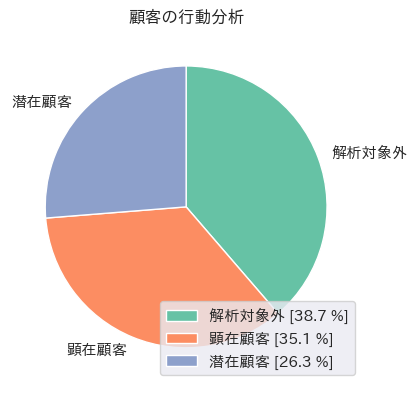

In [ ]:
plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(all_df)):
    label = all_df["index"][i] + " [" + str(round(all_df["rate"][i]*100,1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_df["index"]
y = all_df["rate"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("顧客の行動分析")
plt.legend(labels,loc="lower right");

# 新しいセクション

In [ ]:
client_2 = pd.concat([client_0,client_1,df_train],axis=0).drop_duplicates(keep=False)

In [ ]:
all_2 =len(client_2)
buy =len(client_2[(client_2.num_touch>=1) & (client_2.buy_flag>=1)])
nobuy=len(client_2[(client_2.num_touch>=1) & (client_2.buy_flag==0)])
others = all_2-buy-nobuy

In [ ]:
all_df = pd.DataFrame(columns=["index","each","all","rate"])
all_df["index"]=["接触_購入","接触_非購入","接触なし"]
all_df["each"] =[buy,nobuy,others]
all_df["all"]=all_2
all_df["rate"]= all_df["each"]/all_df["all"]

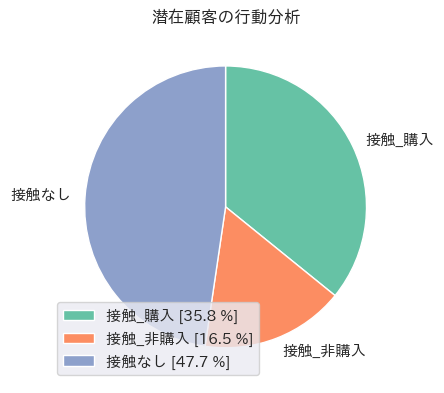

In [ ]:
plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(all_df)):
    label = all_df["index"][i] + " [" + str(round(all_df["rate"][i]*100,1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_df["index"]
y = all_df["rate"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("潜在顧客の行動分析")
plt.legend(labels,loc="lower left");

# 行動分析

In [ ]:
client_2

,gender,age,age_category,num_touch,area_1,area_2,area_3,area_4,area_5,area_time_1,area_time_2,area_time_3,area_time_4,area_time_5,time_duration,in_time,3時のオレ500ml,Cウォーター500ml,あなたのソーダ500ml,あの日のソーダ500ml,うつくし檸檬水500ml,うるうるグリーンティー525ml,おいしい新茶470ml,おいしい時間555ml,おそば屋さんのお茶500ml,かろやかアップル425ml,かろやかオレンジ425ml,きよらかなリンゴ水430ml,こだわりコーヒー無糖500ml,こゆいオレ500ml,ごくごくスポドリ500ml,しゅわしゅわオレンジ420ml,しゅわしゅわプルーン500ml,しゅわしゅわミックスベリー500ml,しゅわしゅわ檸檬ライム470ml,しゅわっとれもん450ml,すっぱいかんきつドリンク400ml,ちょこっとファイバー100ml,つぶつぶミカンジュース400ml,つよーい炭酸水490ml,...,河のせせらぎ500ml,激熱苺480ml,無農薬健康茶600ml,燃えろイナヅマ600ml,燕ブランドのローストグリーンティー525ml,爆発GP480ml,玄米のおいしいお茶500ml,玉露水525ml,職人の力500ml,花の癒し500ml,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml,item_count,かのうハウス,せかいのごはん,イッツ園,エターナル,オールフロント,カルシウムウェイ,クオリティー,ゲーミングファイト,デイリーイースト,トップモード,ネイティブ,フューチャー,モーリーフラフト,ラボラトリー,レジェンド,レモン王,大自然カンパニー,青牛,buy_flag,area_total
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20201026-010015,woman,30's,Young,0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,25.2,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20201026-010017,man,30's,Young,6,1.0,0.0,1.0,0.0,0.0,20.6,0.0,29.0,0.0,0.0,58.4,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
20201026-010019,man,30's,Young,9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,88.2,0.0,0.0,93.8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
20201026-010021,man,10's,Teen,1,0.0,1.0,0.0,0.0,0.0,0.0,3.4,0.0,0.0,0.0,12.6,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20201026-010022,woman,10's,Teen,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.8,4.4,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201101-120045,man,40's,Middle,2,1.0,0.0,0.0,0.0,0.0,13.6,0.0,0.0,0.0,0.0,13.6,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
20201101-120053,man,30's,Young,11,1.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,42.2,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0
20201101-120054,man,30's,Young,3,1.0,0.0,0.0,0.0,0.0,11.2,0.0,0.0,0.0,0.0,28.4,21,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## 0-エリアの素通り顧客

In [ ]:
client_0 = df_train[df_train.num_touch ==0]
client_0 = client_0[client_0.area_total==0]
client_0_ts = df_test[df_test.num_touch ==0]
client_0_ts = client_0_ts[client_0_ts.area_total==0]

others_list=set(list(client_0.index)) ^ set(list(df_train.index)) 
client_0_ex = df_train.loc[others_list]

In [ ]:
df_train.shape

(6795, 173)

In [ ]:
client_0.shape

(2628, 173)

In [ ]:
client_0_ex.shape

(4167, 173)

In [ ]:
client_0.buy_flag.value_counts()

0.0    2628
Name: buy_flag, dtype: int64

In [ ]:
all_age = client_0_ex.age_category.value_counts().reset_index()
nt_age = client_0.age_category.value_counts().reset_index()

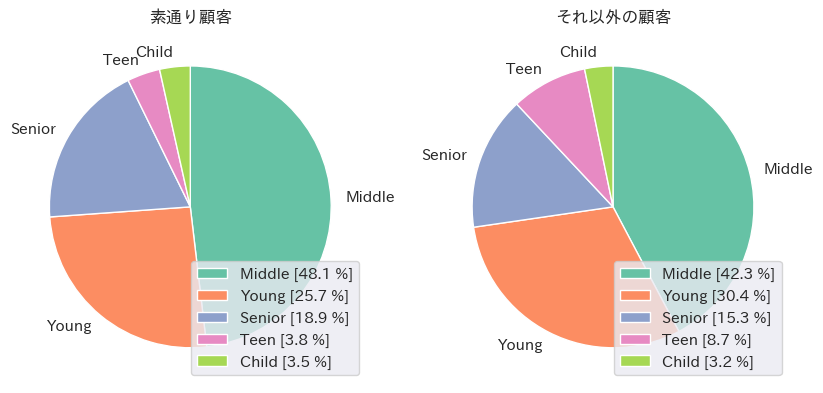

In [ ]:
#年代別分布の可視化

plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(nt_age)):
    label = nt_age["index"][i] + " [" + str(round(nt_age["age_category"][i]*100 / nt_age["age_category"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= nt_age["index"]
y = nt_age["age_category"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("素通り顧客")
plt.legend(labels,loc="lower right");

labels =[]

for i in range(len(all_age)):
    label = all_age["index"][i] + " [" + str(round(all_age["age_category"][i]*100 / all_age["age_category"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_age["index"]
y = all_age["age_category"]

ax = fig.add_subplot(1, 2, 2)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("それ以外の顧客")
plt.legend(labels,loc="lower right");

In [ ]:
all_gender = client_0_ex.gender.value_counts().reset_index()
nt_gender = client_0.gender.value_counts().reset_index()

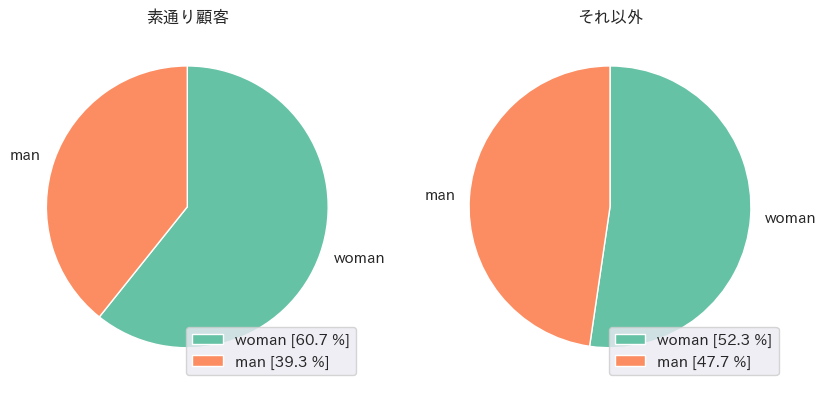

In [ ]:
#性別分布
plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(nt_gender)):
    label = nt_gender["index"][i] + " [" + str(round(nt_gender["gender"][i]*100 / nt_gender["gender"].sum(),1)) + " %" + "]"
    labels.append(label)

x = labels
x= nt_gender["index"]
y = nt_gender["gender"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("素通り顧客")
plt.legend(labels,loc="lower right");

labels =[]

for i in range(len(all_gender)):
    label = all_gender["index"][i] + " [" + str(round(all_gender["gender"][i]*100 / all_gender["gender"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_gender["index"]
y = all_gender["gender"]

ax = fig.add_subplot(1, 2, 2)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("それ以外")
plt.legend(labels,loc="lower right");

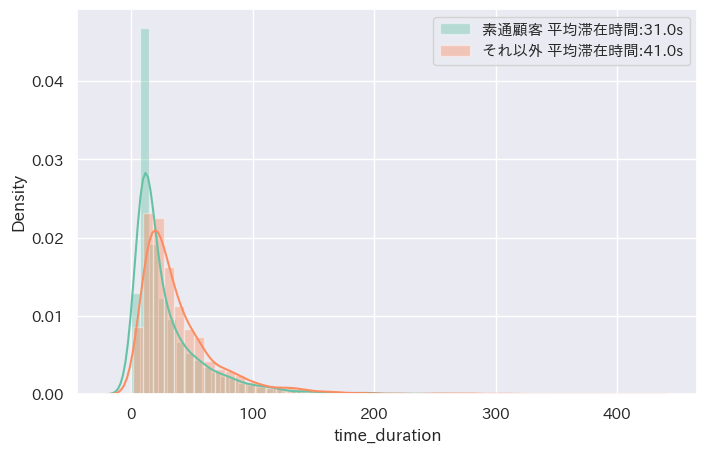

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.distplot(client_0.time_duration,label="素通顧客 平均滞在時間:"+str(round(client_0.time_duration.mean(),0))+"s")
sns.distplot(client_0_ex.time_duration,label="それ以外 平均滞在時間:"+str(round(client_0_ex.time_duration.mean(),0))+"s")
plt.legend()

In [ ]:
xa = client_0_ex["time_duration"]
xb = client_0["time_duration"]
t, p = st.ttest_ind(xa, xb, equal_var=False)
print("t値=", t)
print("p値=", p)

t値= 11.316547715807037
p値= 2.15736283529255e-29


In [ ]:
len(client_0)/len(df_train)

0.38675496688741723

In [ ]:
len(client_0_ts)/len(df_test)

0.39624724061810157

## 1-（顕在顧客) 購入目当ての商品が決まっている

In [ ]:
client_1 = df_train[df_train.num_touch ==df_train.buy_flag]
client_1 = client_1[client_1.buy_flag >=1]

others_list=set(list(client_1.index)) ^ set(list(df_train.index)) 
client_1_ex = df_train.loc[others_list]

In [ ]:
df_train.shape

(6795, 173)

In [ ]:
client_1.shape

(2382, 173)

In [ ]:
client_1_ex.shape

(4413, 173)

In [ ]:
client_1.buy_flag.value_counts()

1.0     1579
2.0      473
3.0      153
4.0       63
5.0       45
6.0       26
10.0      11
7.0       10
8.0        7
15.0       3
14.0       3
11.0       3
12.0       2
9.0        2
20.0       1
13.0       1
Name: buy_flag, dtype: int64

### 1-1　人気の商品

In [ ]:
def item_count(df,item_area):
  items=list(train_org.product_name.unique())[1:]

  #商品カウント
  counts=[]
  for i in items:
    count = sum(df[i].values)
    counts.append(count)

  item_df = pd.DataFrame(columns=["product_name","count"])
  item_df["product_name"]=items
  item_df["count"]=counts

  item_df=item_df.sort_values("count",ascending=False).reset_index(drop=True)
  item_df=pd.merge(item_df,item_area,on="product_name",how="left")

  return item_df

In [ ]:
pop_touch_item = item_count(client_1,item_area)

In [ ]:
#Area-1
pop_touch_item_1=pop_touch_item[pop_touch_item.area_id==1]
pop_touch_item_1.head(50)

,product_name,count,area_id
0,トラディショナル緑茶525ml,196.0,1.0
3,ワイルドティ525ml,135.0,1.0
4,ディープグリーン525ml,115.0,1.0
5,ほっと一息500ml,110.0,1.0
6,新緑の丘525ml,99.0,1.0
7,クリアブラウン525ml,97.0,1.0
9,日本の伝統525ml,81.0,1.0
10,アフタヌーンレモンティー500ml,78.0,1.0
12,マイルドラバー600ml,66.0,1.0
13,ボディベター650ml,66.0,1.0


In [ ]:
#Area-2
pop_touch_item_2=pop_touch_item[pop_touch_item.area_id==2]
pop_touch_item_2.head(10)

,product_name,count,area_id
15,3時のオレ500ml,55.0,2.0
24,黒の息吹500ml,42.0,2.0
34,ワイルドオレ500ml,34.0,2.0
37,コーヒー牛乳500ml,33.0,2.0
39,ボンボヤージュ500ml,32.0,2.0
42,燃えろイナヅマ600ml,31.0,2.0
43,今宵の月500ml,31.0,2.0
45,こゆいオレ500ml,30.0,2.0
46,贅沢の極み500ml,30.0,2.0
49,花束を君に500ml,29.0,2.0


In [ ]:
#Area-3
pop_touch_item_3=pop_touch_item[pop_touch_item.area_id==3]
pop_touch_item_3.head(10)

,product_name,count,area_id
2,ライフパートナー500ml,172.0,3.0
25,ベーシックドリンク500ml,42.0,3.0
27,スペシャルコーク490ml,40.0,3.0
29,ビタミン祭り500ml,37.0,3.0
38,ジンジャーアタック500ml,33.0,3.0
41,スペシャルライフ500ml,31.0,3.0
51,スリーシードル500ml,28.0,3.0
54,あの日のソーダ500ml,26.0,3.0
55,はじけろオレンジ500ml,25.0,3.0
56,はじけたグレープ500ml,24.0,3.0


In [ ]:
#Area-4
pop_touch_item_4=pop_touch_item[pop_touch_item.area_id==4]
pop_touch_item_4.head(10)

,product_name,count,area_id
11,コスモファンタジー500ml,76.0,4.0
22,ごくごくスポドリ500ml,42.0,4.0
30,楊貴妃500ml,37.0,4.0
31,シルクの風490ml,36.0,4.0
32,森の光600ml,35.0,4.0
44,ウェットスポーツ500ml,30.0,4.0
73,うつくし檸檬水500ml,17.0,4.0
77,エッセンス500ml,16.0,4.0
87,乳酸菌たっぷりレモン水500ml,14.0,4.0
88,水玉ウォーター500ml,14.0,4.0


In [ ]:
#Area-5
pop_touch_item_5=pop_touch_item[pop_touch_item.area_id==5]
pop_touch_item_5.head(10)

,product_name,count,area_id
1,ジャパンスプラッシュ500ml,173.0,5.0
8,雪のしずく550ml,88.0,5.0
14,天然水100の炭酸水500ml,57.0,5.0
16,河のせせらぎ500ml,52.0,5.0
26,クリア炭酸500ml,42.0,5.0
33,しゅわしゅわプルーン500ml,35.0,5.0
36,岩清水555ml,33.0,5.0
47,ぱちぱちグレフル500ml,30.0,5.0
48,おいしい時間555ml,30.0,5.0
58,ぱちぱちアセロラドリンク500ml,23.0,5.0


### 1-2　年代

In [ ]:
all_age = client_1_ex.age_category.value_counts().reset_index()
nt_age = client_1.age_category.value_counts().reset_index()

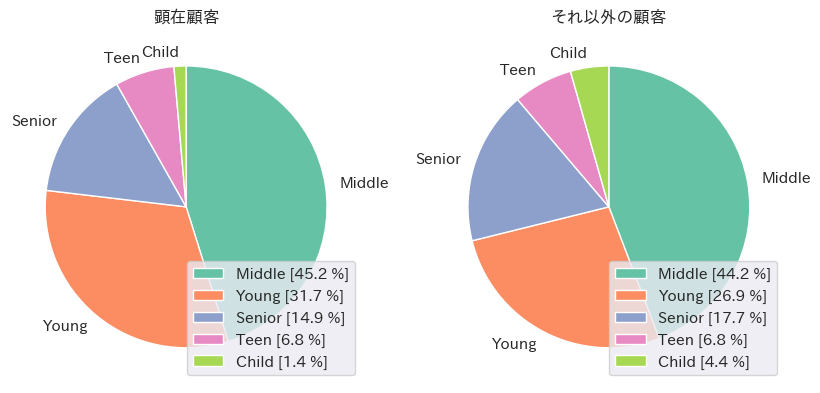

In [ ]:
#年代別分布の可視化

plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(nt_age)):
    label = nt_age["index"][i] + " [" + str(round(nt_age["age_category"][i]*100 / nt_age["age_category"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= nt_age["index"]
y = nt_age["age_category"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("顕在顧客")
plt.legend(labels,loc="lower right");

labels =[]

for i in range(len(all_age)):
    label = all_age["index"][i] + " [" + str(round(all_age["age_category"][i]*100 / all_age["age_category"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_age["index"]
y = all_age["age_category"]

ax = fig.add_subplot(1, 2, 2)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("それ以外の顧客")
plt.legend(labels,loc="lower right");

### 1-3　性別

In [ ]:
all_gender = client_1_ex.gender.value_counts().reset_index()
nt_gender = client_1.gender.value_counts().reset_index()

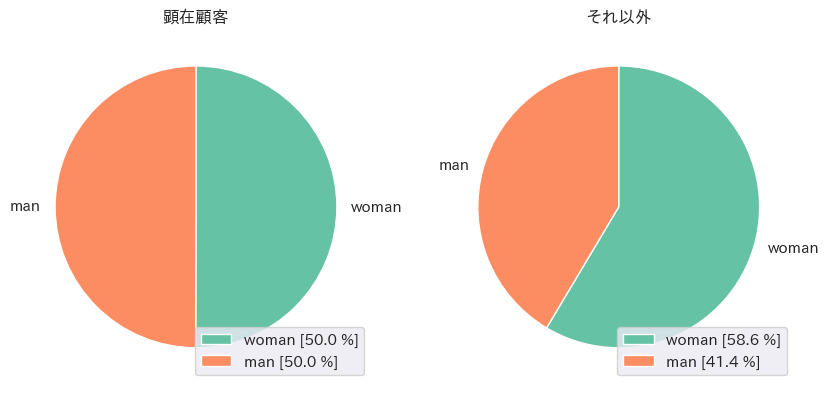

In [ ]:
#性別分布
plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(nt_gender)):
    label = nt_gender["index"][i] + " [" + str(round(nt_gender["gender"][i]*100 / nt_gender["gender"].sum(),1)) + " %" + "]"
    labels.append(label)

x = labels
x= nt_gender["index"]
y = nt_gender["gender"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("顕在顧客")
plt.legend(labels,loc="lower right");

labels =[]

for i in range(len(all_gender)):
    label = all_gender["index"][i] + " [" + str(round(all_gender["gender"][i]*100 / all_gender["gender"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_gender["index"]
y = all_gender["gender"]

ax = fig.add_subplot(1, 2, 2)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("それ以外")
plt.legend(labels,loc="lower right");

### 1-4 滞在時間

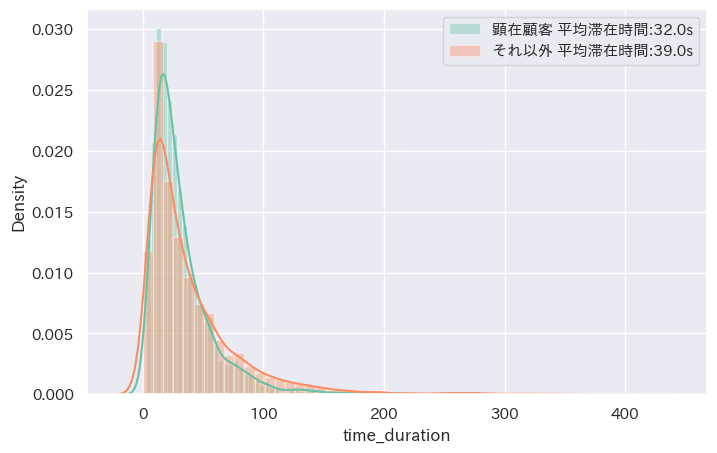

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.distplot(client_1.time_duration,label="顕在顧客 平均滞在時間:"+str(round(client_1.time_duration.mean(),0))+"s")
sns.distplot(client_1_ex.time_duration,label="それ以外 平均滞在時間:"+str(round(client_1_ex.time_duration.mean(),0))+"s")
plt.legend()

In [ ]:
client_1.item_count.value_counts()

1.0    1918
2.0     358
3.0      77
4.0      23
5.0       4
9.0       1
6.0       1
Name: item_count, dtype: int64

### 1-5 購入数と商品数

Text(0, 0.5, '滞在時間')

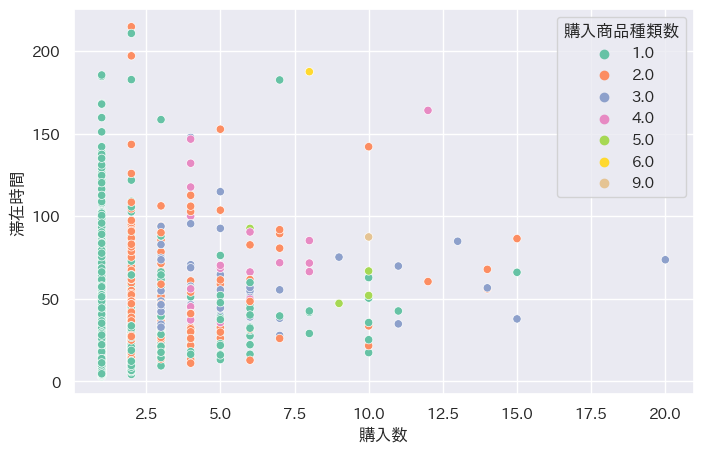

In [ ]:
fig = plt.figure(figsize=(8,5))
client_1["item_count"]=client_1["item_count"].astype("str")
sns.scatterplot(data=client_1, x="buy_flag",y="time_duration",hue="item_count")
plt.legend(title="購入商品種類数")
plt.xlabel("購入数")
plt.ylabel("滞在時間")

### 1-6　侵入エリア

Text(0, 0.5, '回数')

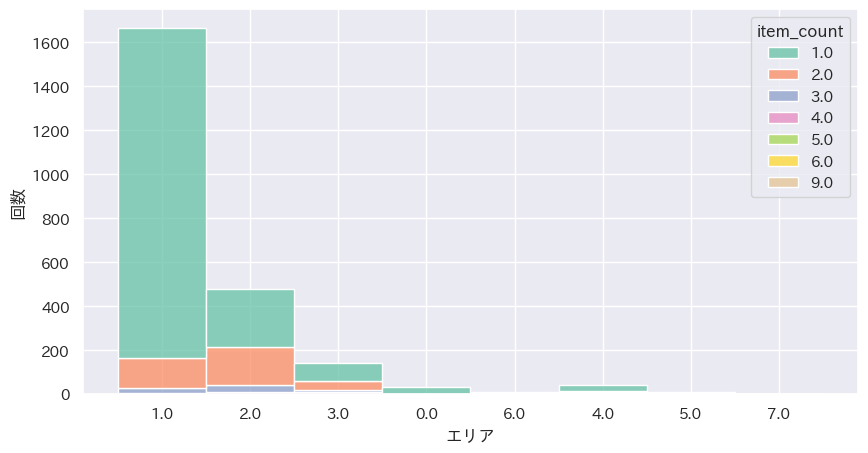

In [ ]:
fig = plt.figure(figsize=(10,5))
#ax = fig.add_subplot(2, 1, 1)
client_1["area_total"]=client_1["area_total"].astype(str)
sns.histplot(data=client_1, x="area_total",hue="item_count", multiple="stack",binwidth=0.6)
#plt.legend(title="購入商品種類数")
plt.xlabel("エリア")
plt.ylabel("回数")


#ax = fig.add_subplot(2, 1, 2)
#client_1_ex["area_total"]=client_1_ex["area_total"].astype(float)
#sns.histplot(data=client_1_ex, x="area_total",hue="item_count")
#plt.legend(title="購入商品種類数")
#plt.xlabel("エリア")
#plt.ylabel("回数")

### 1-7　時間帯

Text(0.5, 1.0, 'それ以外の顧客')

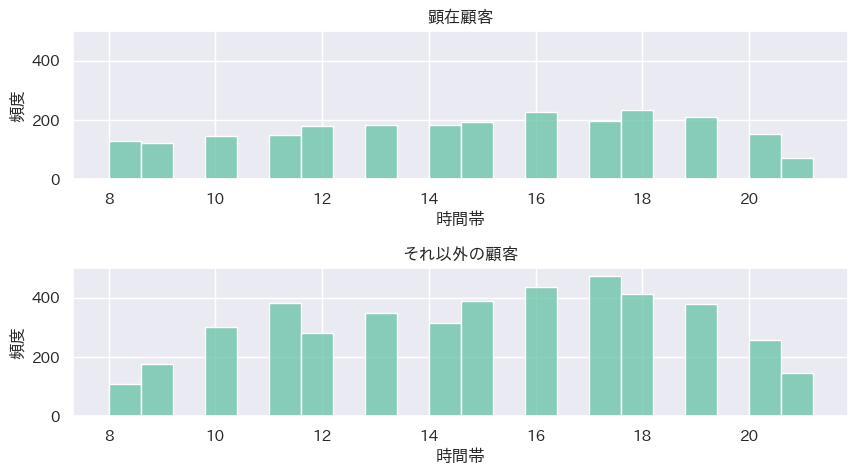

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(2, 1, 1)
fig.subplots_adjust(hspace=0.6)
    
client_1["in_time"]=client_1["in_time"].astype(float)
sns.histplot(data=client_1, x="in_time",binwidth=0.6)
plt.xlabel("時間帯")
plt.ylabel("頻度")
plt.ylim(0,500)
plt.title("顕在顧客")


ax = fig.add_subplot(2, 1, 2)
client_1_ex["in_time"]=client_1_ex["in_time"].astype(float)
sns.histplot(data=client_1_ex, x="in_time",binwidth=0.6)
plt.xlabel("時間帯")
plt.ylabel("頻度")
plt.ylim(0,500)
plt.title("それ以外の顧客")

In [ ]:
len(client_1)/len(df_train)

0.35055187637969093

## 2-特に購入は決まっておらず品定めしている潜在顧客

In [ ]:
client_2 = df_train[df_train.num_touch > df_train.buy_flag]
client_2 = client_2[client_2.item_count > 1]

others_list=set(list(client_2.index)) ^ set(list(df_train.index)) 
client_2_ex = df_train.loc[others_list]

In [ ]:
df_train.shape

(6795, 173)

In [ ]:
client_2.shape

(579, 173)

In [ ]:
client_2_ex.shape

(6216, 173)

In [ ]:
client_2.buy_flag.value_counts()

1.0     294
2.0     109
0.0      72
3.0      50
4.0      28
5.0      11
6.0       6
7.0       3
8.0       2
9.0       2
14.0      1
12.0      1
Name: buy_flag, dtype: int64

### 2-1 年代

In [ ]:
all_age = client_2_ex.age_category.value_counts().reset_index()
nt_age = client_2.age_category.value_counts().reset_index()

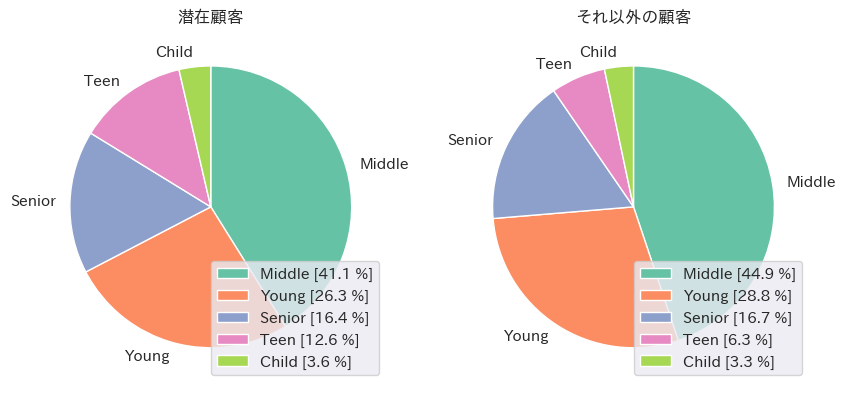

In [ ]:
#年代別分布の可視化

plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(nt_age)):
    label = nt_age["index"][i] + " [" + str(round(nt_age["age_category"][i]*100 / nt_age["age_category"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= nt_age["index"]
y = nt_age["age_category"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("潜在顧客")
plt.legend(labels,loc="lower right");

labels =[]

for i in range(len(all_age)):
    label = all_age["index"][i] + " [" + str(round(all_age["age_category"][i]*100 / all_age["age_category"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_age["index"]
y = all_age["age_category"]

ax = fig.add_subplot(1, 2, 2)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("それ以外の顧客")
plt.legend(labels,loc="lower right");

### 2-2 性別

In [ ]:
all_gender = client_2_ex.gender.value_counts().reset_index()
nt_gender = client_2.gender.value_counts().reset_index()

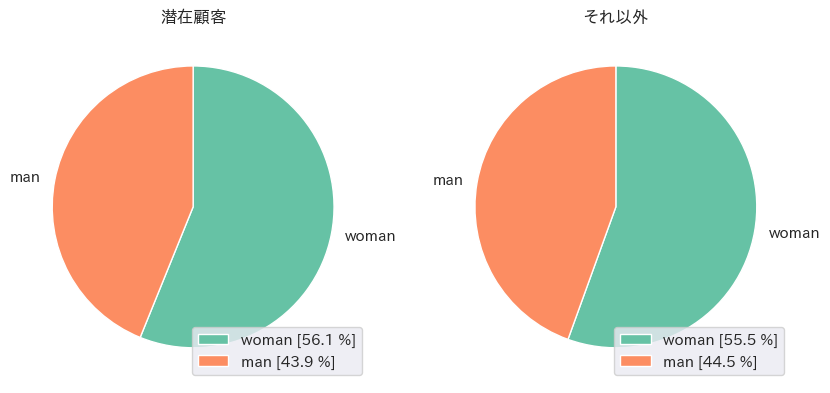

In [ ]:
#性別分布
plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(nt_gender)):
    label = nt_gender["index"][i] + " [" + str(round(nt_gender["gender"][i]*100 / nt_gender["gender"].sum(),1)) + " %" + "]"
    labels.append(label)

x = labels
x= nt_gender["index"]
y = nt_gender["gender"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("潜在顧客")
plt.legend(labels,loc="lower right");

labels =[]

for i in range(len(all_gender)):
    label = all_gender["index"][i] + " [" + str(round(all_gender["gender"][i]*100 / all_gender["gender"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_gender["index"]
y = all_gender["gender"]

ax = fig.add_subplot(1, 2, 2)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("それ以外")
plt.legend(labels,loc="lower right");

### 2-3 滞在時間

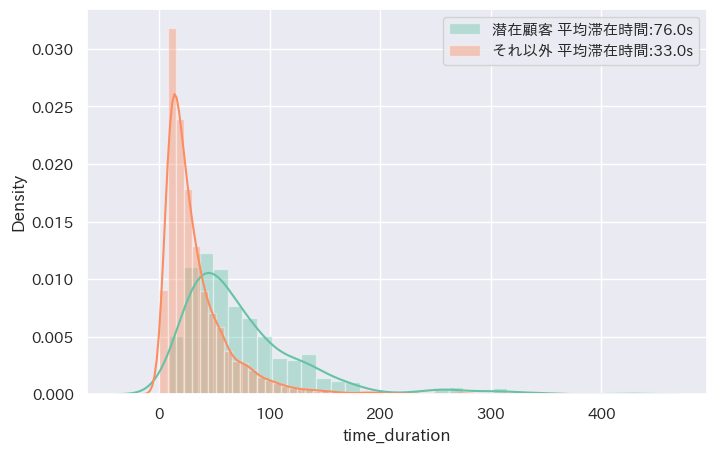

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.distplot(client_2.time_duration,label="潜在顧客 平均滞在時間:"+str(round(client_2.time_duration.mean(),0))+"s")
sns.distplot(client_2_ex.time_duration,label="それ以外 平均滞在時間:"+str(round(client_2_ex.time_duration.mean(),0))+"s")
plt.legend()

In [ ]:
client_2.item_count.value_counts()

2.0     319
3.0     146
4.0      56
5.0      31
6.0      10
8.0       7
7.0       5
10.0      2
16.0      1
12.0      1
11.0      1
Name: item_count, dtype: int64

### 2-4 購入数と商品数

Text(0, 0.5, '滞在時間')

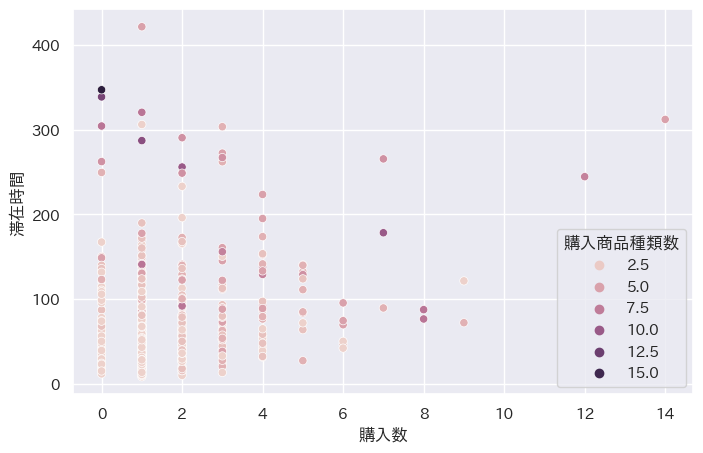

In [ ]:
fig = plt.figure(figsize=(8,5))
client_2["item_count"]=client_2["item_count"].astype(float)
sns.scatterplot(data=client_2, x="buy_flag",y="time_duration",hue="item_count")
plt.legend(title="購入商品種類数")
plt.xlabel("購入数")
plt.ylabel("滞在時間")

### 2-5 侵入エリア

(0.0, 10.0)

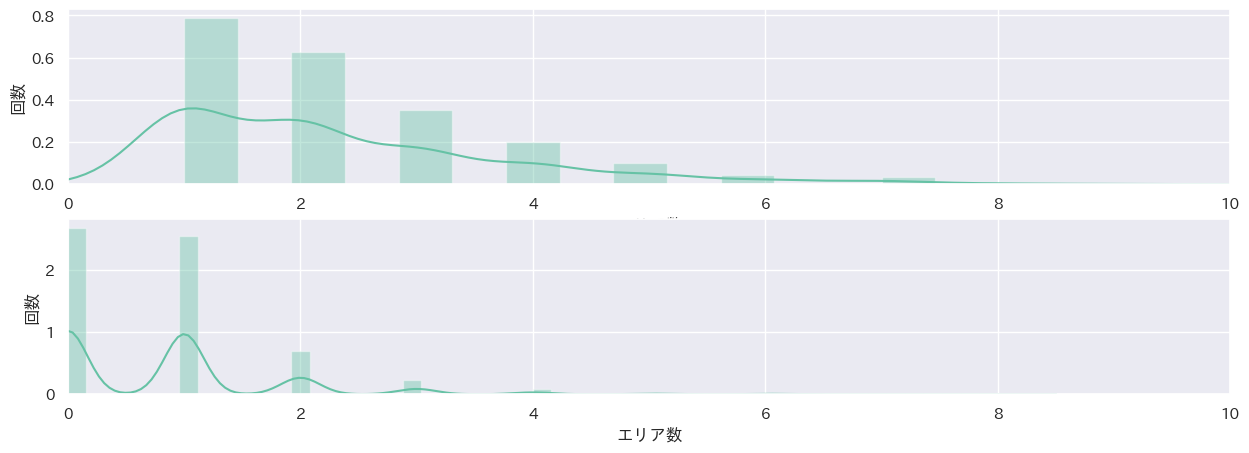

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(2, 1, 1)
client_2["area_total"]=client_2["area_total"].astype(str)
#sns.histplot(data=client_2, x="area_total",hue="item_count", multiple="stack",binwidth=0.6)
sns.distplot(client_2["area_total"])
#plt.legend(title="購入商品種類数")
plt.xlabel("エリア数")
plt.ylabel("回数")
plt.xlim(0,10)


ax = fig.add_subplot(2, 1, 2)
client_2_ex["area_total"]=client_2_ex["area_total"].astype(str)
sns.distplot(client_2_ex["area_total"])
#sns.histplot(data=client_1_ex, x="area_total",hue="item_count")
#plt.legend(title="購入商品種類数")
plt.xlabel("エリア数")
plt.ylabel("回数")
plt.xlim(0,10)

In [ ]:
print("Area_1: " +str(client_2.area_1.sum()))
print("Area_2: " +str(client_2.area_2.sum()))
print("Area_3: " +str(client_2.area_3.sum()))
print("Area_4: " +str(client_2.area_4.sum()))
print("Area_5: " +str(client_2.area_5.sum()))


Area_1: 393.0
Area_2: 232.0
Area_3: 379.0
Area_4: 152.0
Area_5: 197.0


### 2-5 時間帯

Text(0.5, 1.0, 'それ以外の顧客')

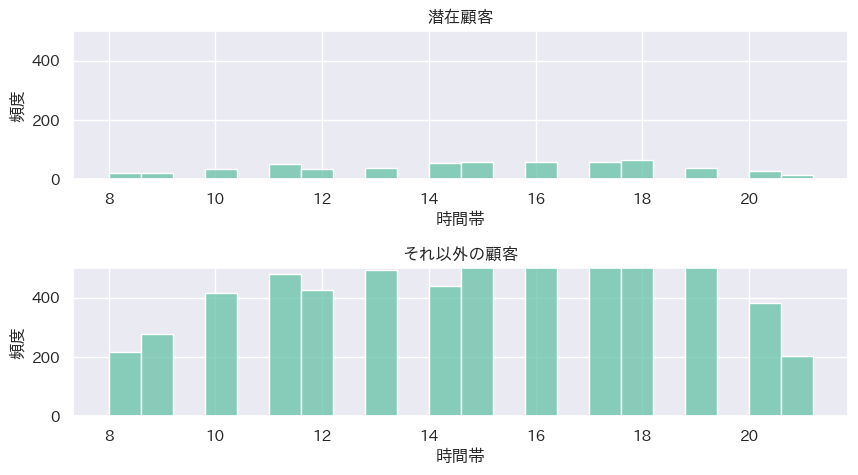

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(2, 1, 1)
fig.subplots_adjust(hspace=0.6)
    
client_2["in_time"]=client_2["in_time"].astype(float)
sns.histplot(data=client_2, x="in_time",binwidth=0.6)
plt.xlabel("時間帯")
plt.ylabel("頻度")
plt.ylim(0,500)
plt.title("潜在顧客")


ax = fig.add_subplot(2, 1, 2)
client_2_ex["in_time"]=client_2_ex["in_time"].astype(float)
sns.histplot(data=client_2_ex, x="in_time",binwidth=0.6)
plt.xlabel("時間帯")
plt.ylabel("頻度")
plt.ylim(0,500)
plt.title("それ以外の顧客")

In [ ]:
len(client_2)/len(df_train)

0.08520971302428255

## 3-接触回数の多い人の購入商品種類数

In [ ]:
# ２回以上接触する人
client_3 = df_train[df_train.num_touch > 1]
#client_3 = client_3[client_3.item_count>= 1]

In [ ]:
client_3.buy_flag.value_counts()

2.0     603
1.0     391
3.0     210
0.0      97
4.0      96
5.0      56
6.0      33
7.0      13
10.0     11
8.0       9
9.0       5
14.0      4
11.0      3
12.0      3
15.0      3
13.0      1
20.0      1
Name: buy_flag, dtype: int64

In [ ]:
client_3.shape

(1539, 173)

In [ ]:
len(client_3)/len(df_train)

0.22649006622516557

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '頻度')

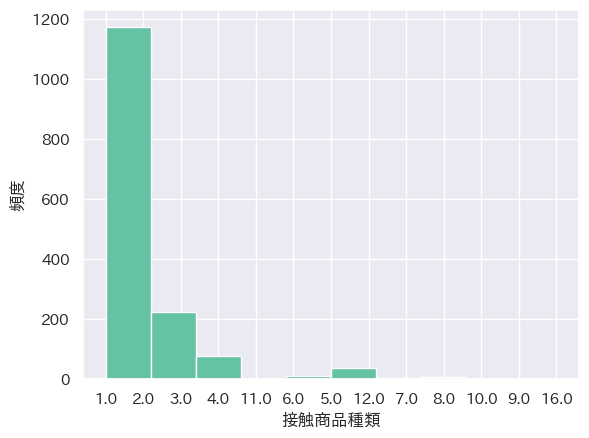

In [ ]:
client_3["item_count"]=client_3["item_count"].astype(str)
client_3.item_count.hist()
plt.xlabel("接触商品種類")
plt.ylabel("頻度")

## 4-複数回同じ商品に接触する人

In [ ]:
client_4 = df_train[df_train.num_touch > 1]
client_4 = client_4[client_4.buy_flag== 1]

In [ ]:
client_5 = df_train[df_train.num_touch > 1]
client_5 = client_5[client_5.item_count== 1]

In [ ]:
client_5.buy_flag.value_counts()

2.0     237
1.0      97
3.0      67
4.0      26
0.0      25
5.0      20
6.0      11
10.0      5
8.0       3
7.0       2
15.0      1
11.0      1
9.0       1
Name: buy_flag, dtype: int64

In [ ]:
client_4.shape

(391, 173)

Text(0, 0.5, '頻度')

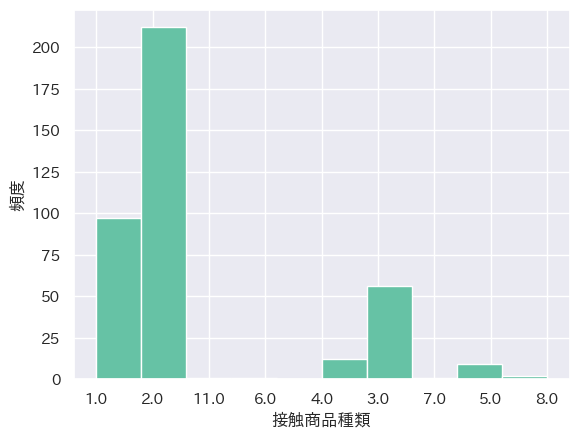

In [ ]:
client_4["item_count"]=client_4["item_count"].astype(str)
client_4.item_count.hist()
plt.xlabel("接触商品種類")
plt.ylabel("頻度")

In [ ]:
len(client_4)/len(df_train)

0.05754231052244297

In [ ]:
client_4.head()

,gender,age,age_category,num_touch,area_1,area_2,area_3,area_4,area_5,area_time_1,area_time_2,area_time_3,area_time_4,area_time_5,time_duration,in_time,3時のオレ500ml,Cウォーター500ml,あなたのソーダ500ml,あの日のソーダ500ml,うつくし檸檬水500ml,うるうるグリーンティー525ml,おいしい新茶470ml,おいしい時間555ml,おそば屋さんのお茶500ml,かろやかアップル425ml,かろやかオレンジ425ml,きよらかなリンゴ水430ml,こだわりコーヒー無糖500ml,こゆいオレ500ml,ごくごくスポドリ500ml,しゅわしゅわオレンジ420ml,しゅわしゅわプルーン500ml,しゅわしゅわミックスベリー500ml,しゅわしゅわ檸檬ライム470ml,しゅわっとれもん450ml,すっぱいかんきつドリンク400ml,ちょこっとファイバー100ml,つぶつぶミカンジュース400ml,つよーい炭酸水490ml,...,河のせせらぎ500ml,激熱苺480ml,無農薬健康茶600ml,燃えろイナヅマ600ml,燕ブランドのローストグリーンティー525ml,爆発GP480ml,玄米のおいしいお茶500ml,玉露水525ml,職人の力500ml,花の癒し500ml,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml,item_count,かのうハウス,せかいのごはん,イッツ園,エターナル,オールフロント,カルシウムウェイ,クオリティー,ゲーミングファイト,デイリーイースト,トップモード,ネイティブ,フューチャー,モーリーフラフト,ラボラトリー,レジェンド,レモン王,大自然カンパニー,青牛,buy_flag,area_total
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20201026-010019,man,30's,Young,9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,88.2,0.0,0.0,93.8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
20201026-010033,man,40's,Middle,4,1.0,1.0,1.0,1.0,0.0,4.6,10.2,23.6,5.8,0.0,55.4,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
20201026-010056,woman,20's,Young,3,1.0,0.0,0.0,0.0,0.0,55.8,0.0,0.0,0.0,0.0,69.0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
20201026-010058,woman,60's,Senior,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,8.4,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
20201026-010062,woman,40's,Middle,2,1.0,0.0,0.0,0.0,0.0,21.6,0.0,0.0,0.0,0.0,34.4,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
train_org[train_org.customer_id =="20201026-010019"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag
13,20201026-010019,2020/10/26,NaN,man,30's,Young,1,NaN,NaN,NaN,93.8,NaN,08:20:36.600,08:22:10.400,NaN
5503,20201026-010019,2020/10/26,3.0,man,30's,Young,2,NaN,NaN,NaN,88.2,NaN,08:20:39.800,08:22:08.000,NaN
10777,20201026-010019,2020/10/26,NaN,man,30's,Young,3,9.0,はじけろオレンジ500ml,フューチャー,0.0,1.0,08:20:41.800,NaN,0.0
10778,20201026-010019,2020/10/26,NaN,man,30's,Young,3,9.0,はじけろオレンジ500ml,フューチャー,0.0,1.0,08:21:08.200,NaN,0.0
10779,20201026-010019,2020/10/26,NaN,man,30's,Young,3,9.0,はじけろオレンジ500ml,フューチャー,0.0,1.0,08:21:14.000,NaN,0.0
10780,20201026-010019,2020/10/26,NaN,man,30's,Young,3,9.0,はじけろオレンジ500ml,フューチャー,0.0,1.0,08:21:15.400,NaN,0.0
10781,20201026-010019,2020/10/26,NaN,man,30's,Young,3,9.0,はじけろオレンジ500ml,フューチャー,0.0,1.0,08:21:26.000,NaN,0.0
10782,20201026-010019,2020/10/26,NaN,man,30's,Young,3,9.0,はじけろオレンジ500ml,フューチャー,0.0,1.0,08:21:28.600,NaN,0.0
10783,20201026-010019,2020/10/26,NaN,man,30's,Young,3,9.0,はじけろオレンジ500ml,フューチャー,0.0,1.0,08:21:29.000,NaN,0.0
10784,20201026-010019,2020/10/26,NaN,man,30's,Young,3,9.0,はじけろオレンジ500ml,フューチャー,0.0,1.0,08:21:34.600,NaN,1.0


In [ ]:
train_org[train_org.customer_id =="20201026-010056"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag
41,20201026-010056,2020/10/26,NaN,woman,20's,Young,1,NaN,NaN,NaN,69.0,NaN,08:55:24.000,08:56:33.000,NaN
5537,20201026-010056,2020/10/26,1.0,woman,20's,Young,2,NaN,NaN,NaN,55.8,NaN,08:55:32.000,08:56:27.800,NaN
10822,20201026-010056,2020/10/26,NaN,woman,20's,Young,3,17.0,伝統の技525ml,イッツ園,0.0,1.0,08:55:49.000,NaN,0.0
10823,20201026-010056,2020/10/26,NaN,woman,20's,Young,3,17.0,伝統の技525ml,イッツ園,0.0,1.0,08:56:03.200,NaN,0.0
10824,20201026-010056,2020/10/26,NaN,woman,20's,Young,3,12.0,摘みたて茶葉430ml,エターナル,0.0,1.0,08:56:23.000,NaN,1.0


## 5-商品をタッチしても購入しない (離脱客)

In [ ]:
client_4 = df_train[df_train.num_touch >=1]
client_4 = client_4[client_4.buy_flag == 0]

others_list=set(list(client_4.index)) ^ set(list(df_train.index)) 
client_4_ex = df_train.loc[others_list]

In [ ]:
len(client_4)/len(df_train)

0.043561442236938926

In [ ]:
all_age = client_4_ex.age_category.value_counts().reset_index()
nt_age = client_4.age_category.value_counts().reset_index()

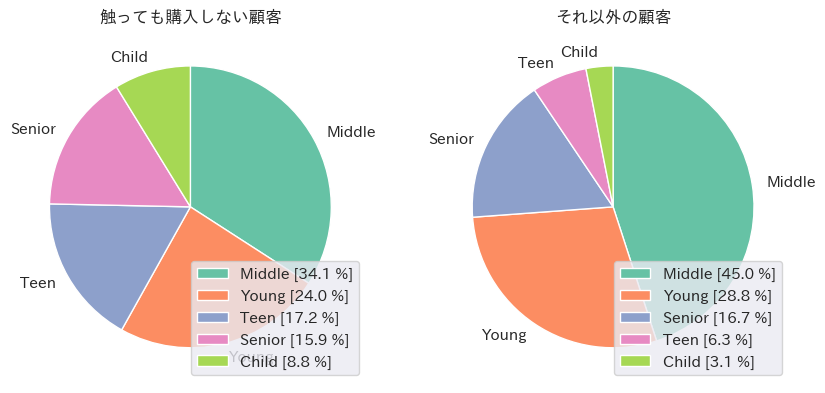

In [ ]:
#年代別分布の可視化

plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(nt_age)):
    label = nt_age["index"][i] + " [" + str(round(nt_age["age_category"][i]*100 / nt_age["age_category"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= nt_age["index"]
y = nt_age["age_category"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("触っても購入しない顧客")
plt.legend(labels,loc="lower right");

labels =[]

for i in range(len(all_age)):
    label = all_age["index"][i] + " [" + str(round(all_age["age_category"][i]*100 / all_age["age_category"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_age["index"]
y = all_age["age_category"]

ax = fig.add_subplot(1, 2, 2)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("それ以外の顧客")
plt.legend(labels,loc="lower right");

In [ ]:
all_age = client_4_ex.age.value_counts().reset_index()
nt_age = client_4.age.value_counts().reset_index()

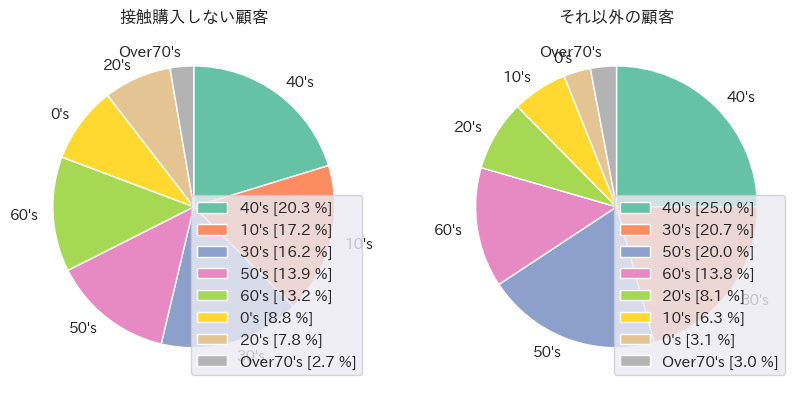

In [ ]:
#年代別分布の可視化

plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(nt_age)):
    label = nt_age["index"][i] + " [" + str(round(nt_age["age"][i]*100 / nt_age["age"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= nt_age["index"]
y = nt_age["age"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("接触購入しない顧客")
plt.legend(labels,loc="lower right");

labels =[]

for i in range(len(all_age)):
    label = all_age["index"][i] + " [" + str(round(all_age["age"][i]*100 / all_age["age"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_age["index"]
y = all_age["age"]

ax = fig.add_subplot(1, 2, 2)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("それ以外の顧客")
plt.legend(labels,loc="lower right");

In [ ]:
all_gender = client_4_ex.gender.value_counts().reset_index()
nt_gender = client_4.gender.value_counts().reset_index()

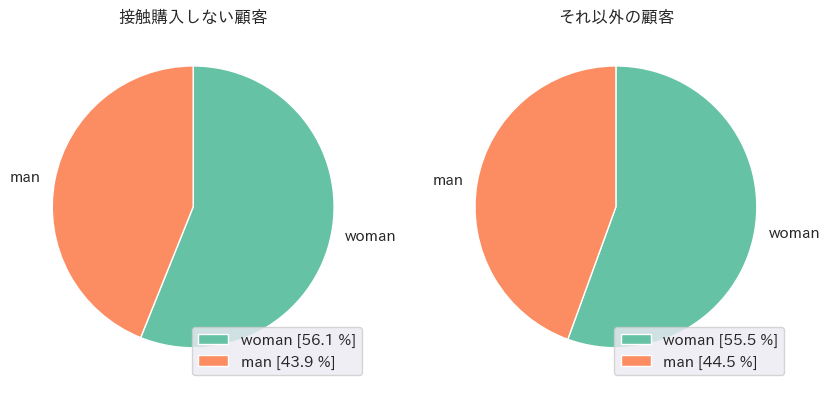

In [ ]:
#性別分布
plt.style.use('default')
sns.set_style('whitegrid')
sns.set(font="IPAexGothic") 
sns.set_palette('Set2')


labels =[]

for i in range(len(nt_gender)):
    label = nt_gender["index"][i] + " [" + str(round(nt_gender["gender"][i]*100 / nt_gender["gender"].sum(),1)) + " %" + "]"
    labels.append(label)

x = labels
x= nt_gender["index"]
y = nt_gender["gender"]
 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("接触購入しない顧客")
plt.legend(labels,loc="lower right");

labels =[]

for i in range(len(all_gender)):
    label = all_gender["index"][i] + " [" + str(round(all_gender["gender"][i]*100 / all_gender["gender"].sum(),1)) + " %" + "]"
    labels.append(label)


x = labels
x= all_gender["index"]
y = all_gender["gender"]

ax = fig.add_subplot(1, 2, 2)
ax.pie(y, counterclock=False,startangle=90,rotatelabels=False, labels=x);
plt.title("それ以外の顧客")
plt.legend(labels,loc="lower right");

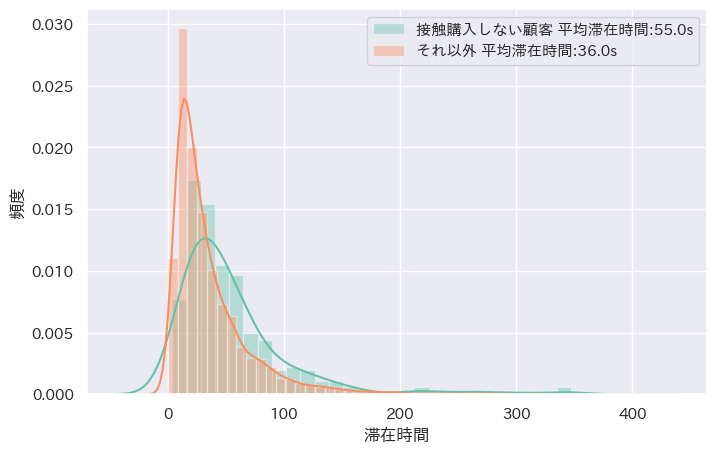

In [ ]:
#滞在時間
fig = plt.figure(figsize=(8,5))
sns.distplot(client_4.time_duration,label="接触購入しない顧客 平均滞在時間:"+str(round(client_4.time_duration.mean(),0))+"s")
sns.distplot(client_4_ex.time_duration,label="それ以外 平均滞在時間:"+str(round(client_4_ex.time_duration.mean(),0))+"s")
plt.xlabel("滞在時間")
plt.ylabel("頻度")
plt.legend()

Text(0, 0.5, '頻度')

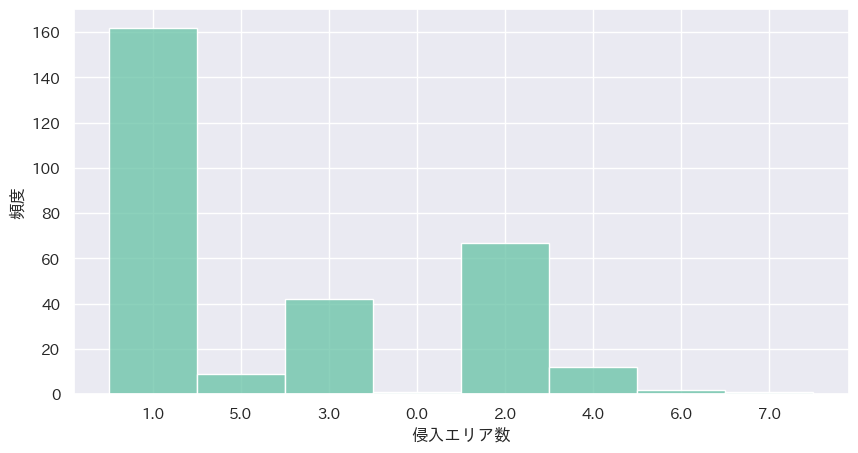

In [ ]:
#エリア侵入回数
fig = plt.figure(figsize=(10,5))
#ax = fig.add_subplot(2, 1, 1)
client_4["area_total"]=client_4["area_total"].astype(str)
sns.histplot(data=client_4, x="area_total", multiple="stack",binwidth=0.6)
#plt.legend(title="購入商品種類数")
plt.xlabel("侵入エリア数")
plt.ylabel("頻度")


In [ ]:
client_4

,gender,age,age_category,num_touch,area_1,area_2,area_3,area_4,area_5,area_time_1,area_time_2,area_time_3,area_time_4,area_time_5,time_duration,in_time,3時のオレ500ml,Cウォーター500ml,あなたのソーダ500ml,あの日のソーダ500ml,うつくし檸檬水500ml,うるうるグリーンティー525ml,おいしい新茶470ml,おいしい時間555ml,おそば屋さんのお茶500ml,かろやかアップル425ml,かろやかオレンジ425ml,きよらかなリンゴ水430ml,こだわりコーヒー無糖500ml,こゆいオレ500ml,ごくごくスポドリ500ml,しゅわしゅわオレンジ420ml,しゅわしゅわプルーン500ml,しゅわしゅわミックスベリー500ml,しゅわしゅわ檸檬ライム470ml,しゅわっとれもん450ml,すっぱいかんきつドリンク400ml,ちょこっとファイバー100ml,つぶつぶミカンジュース400ml,つよーい炭酸水490ml,...,河のせせらぎ500ml,激熱苺480ml,無農薬健康茶600ml,燃えろイナヅマ600ml,燕ブランドのローストグリーンティー525ml,爆発GP480ml,玄米のおいしいお茶500ml,玉露水525ml,職人の力500ml,花の癒し500ml,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml,item_count,かのうハウス,せかいのごはん,イッツ園,エターナル,オールフロント,カルシウムウェイ,クオリティー,ゲーミングファイト,デイリーイースト,トップモード,ネイティブ,フューチャー,モーリーフラフト,ラボラトリー,レジェンド,レモン王,大自然カンパニー,青牛,buy_flag,area_total
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20201026-010021,man,10's,Teen,1,0.0,1.0,0.0,0.0,0.0,0.0,3.4,0.0,0.0,0.0,12.6,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20201026-010022,woman,10's,Teen,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.8,4.4,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20201026-010032,man,50's,Middle,1,1.0,0.0,0.0,0.0,0.0,13.8,0.0,0.0,0.0,0.0,23.2,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20201026-010072,woman,60's,Senior,3,1.0,0.0,0.0,0.0,0.0,17.6,0.0,0.0,0.0,0.0,28.6,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
20201026-010093,woman,30's,Young,1,1.0,0.0,0.0,0.0,0.0,11.4,0.0,0.0,0.0,0.0,25.2,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201101-110040,man,10's,Teen,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,56.4,0.0,0.0,105.8,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
20201101-110098,woman,10's,Teen,1,1.0,1.0,0.0,0.0,0.0,42.4,31.8,0.0,0.0,0.0,87.4,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
20201101-110100,man,30's,Young,1,0.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,18.2,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Childrenの購入しない商品

In [ ]:
child_touch = client_4[client_4.age_category=="Child"].reset_index(drop=True)

In [ ]:
len(child_touch)

26

In [ ]:
child_touch_item = item_count(child_touch,item_area)

In [ ]:
child_touch_item.head(10)

,product_name,count,area_id
0,はじけろオレンジ500ml,9.0,3.0
1,ベーシックドリンク500ml,6.0,3.0
2,はじけたグレープ500ml,5.0,3.0
3,サンライズ470ml,5.0,3.0
4,あの日のソーダ500ml,4.0,3.0
5,キッズアップル470ml,4.0,3.0
6,ライフパートナー500ml,3.0,3.0
7,あなたのソーダ500ml,3.0,3.0
8,水玉ウォーター500ml,2.0,4.0
9,マイルドラバー600ml,2.0,1.0


### Teenの購入しない商品

In [ ]:
teen_touch = client_4[client_4.age_category=="Teen"].reset_index(drop=True)
teen_touch_item = item_count(teen_touch,item_area)

In [ ]:
len(teen_touch)

51

In [ ]:
teen_touch_item.head(10)

,product_name,count,area_id
0,キッズアップル470ml,13.0,3.0
1,サンライズ470ml,8.0,3.0
2,ファイナルカード355ml,7.0,3.0
3,パワーオブビースト355ml,6.0,3.0
4,ウィングパワードリンク250ml,6.0,3.0
5,はじけたグレープ500ml,5.0,3.0
6,うるうるグリーンティー525ml,5.0,1.0
7,ハードコア120ml,4.0,3.0
8,ジンジャーアタック500ml,3.0,3.0
9,ほっと一息500ml,3.0,1.0


### Youngの購入しない商品

In [ ]:
young_touch = client_4[client_4.age_category=="Young"].reset_index(drop=True)
young_touch_item = item_count(young_touch,item_area)

In [ ]:
len(young_touch)

71

In [ ]:
young_touch_item.head(10)

,product_name,count,area_id
0,マイルドラバー600ml,6.0,1.0
1,ミルクマシマシラテ450ml,6.0,2.0
2,キッズアップル470ml,5.0,3.0
3,スペシャルライフ500ml,4.0,3.0
4,ライフパートナー500ml,3.0,3.0
5,ボディベター650ml,3.0,1.0
6,ビタミン祭り500ml,2.0,3.0
7,伝統の技525ml,2.0,1.0
8,スカッと檸檬500ml,2.0,3.0
9,トラディショナル緑茶525ml,2.0,1.0


### Middleの購入しない商品

In [ ]:
mid_touch = client_4[client_4.age_category=="Middle"].reset_index(drop=True)
mid_touch_item = item_count(mid_touch,item_area)

In [ ]:
len(mid_touch)

101

In [ ]:
mid_touch_item.head(10)

,product_name,count,area_id
0,うるうるグリーンティー525ml,15.0,1.0
1,しゅわしゅわプルーン500ml,10.0,5.0
2,ミックスフルーツドリンク500ml,7.0,3.0
3,ディープグリーン525ml,6.0,1.0
4,ジャパンスプラッシュ500ml,5.0,5.0
5,新緑の丘525ml,5.0,1.0
6,ミルクマシマシラテ450ml,5.0,2.0
7,ボンボヤージュ500ml,5.0,2.0
8,黒の息吹500ml,5.0,2.0
9,トラディショナル緑茶525ml,4.0,1.0


### Seniorの購入しない商品

In [ ]:
sen_touch = client_4[client_4.age_category=="Senior"].reset_index(drop=True)
sen_touch_item = item_count(sen_touch,item_area)

In [ ]:
len(sen_touch)

47

In [ ]:
sen_touch_item.head(10)

,product_name,count,area_id
0,新緑の丘525ml,5.0,1.0
1,ディープグリーン525ml,4.0,1.0
2,伝統の技525ml,4.0,1.0
3,ワイルドティ525ml,4.0,1.0
4,3時のオレ500ml,3.0,2.0
5,ハードコア120ml,3.0,3.0
6,こゆいオレ500ml,2.0,2.0
7,黒の息吹500ml,2.0,2.0
8,エッセンス500ml,2.0,4.0
9,今宵の月500ml,2.0,2.0


### エリア別

In [ ]:
touch_item = item_count(client_4,item_area)

In [ ]:
touch_item

,product_name,count,area_id
0,キッズアップル470ml,23.0,3.0
1,うるうるグリーンティー525ml,20.0,1.0
2,新緑の丘525ml,14.0,1.0
3,サンライズ470ml,13.0,3.0
4,ミルクマシマシラテ450ml,11.0,2.0
...,...,...,...
131,乳酸菌たっぷりレモン水500ml,0.0,4.0
132,イエローサイダー500ml,0.0,3.0
133,すっぱいかんきつドリンク400ml,0.0,3.0
134,マンダリンショット500ml,0.0,5.0


In [ ]:
#Area-1
area_1=touch_item[touch_item.area_id==1]
area_1.head(5)

,product_name,count,area_id
1,うるうるグリーンティー525ml,20.0,1.0
2,新緑の丘525ml,14.0,1.0
5,ディープグリーン525ml,11.0,1.0
8,伝統の技525ml,10.0,1.0
10,トラディショナル緑茶525ml,10.0,1.0


In [ ]:
#Area-2
area_2=touch_item[touch_item.area_id==2]
area_2.head(10)

,product_name,count,area_id
4,ミルクマシマシラテ450ml,11.0,2.0
19,ボンボヤージュ500ml,8.0,2.0
20,黒の息吹500ml,7.0,2.0
26,花束を君に500ml,6.0,2.0
27,こゆいオレ500ml,6.0,2.0
28,3時のオレ500ml,6.0,2.0
40,今宵の月500ml,5.0,2.0
45,燃えろイナヅマ600ml,4.0,2.0
60,ハイテンション250ml,3.0,2.0
68,こだわりコーヒー無糖500ml,3.0,2.0


In [ ]:
#Area-3
area_3=touch_item[touch_item.area_id==3]
area_3.head(10)

,product_name,count,area_id
0,キッズアップル470ml,23.0,3.0
3,サンライズ470ml,13.0,3.0
6,はじけたグレープ500ml,11.0,3.0
7,はじけろオレンジ500ml,11.0,3.0
11,ベーシックドリンク500ml,9.0,3.0
13,ミックスフルーツドリンク500ml,9.0,3.0
14,ハードコア120ml,9.0,3.0
15,ライフパートナー500ml,9.0,3.0
22,ファイナルカード355ml,7.0,3.0
23,パワーオブビースト355ml,6.0,3.0


In [ ]:
#Area-4
area_4=touch_item[touch_item.area_id==4]
area_4.head(10)

,product_name,count,area_id
31,楊貴妃500ml,6.0,4.0
33,うつくし檸檬水500ml,5.0,4.0
39,シルクの風490ml,5.0,4.0
54,エッセンス500ml,4.0,4.0
57,森の光600ml,3.0,4.0
80,Cウォーター500ml,2.0,4.0
91,水玉ウォーター500ml,2.0,4.0
100,コスモファンタジー500ml,2.0,4.0
101,ごくごくスポドリ500ml,2.0,4.0
108,ビタミンたっぷりレモン水500ml,1.0,4.0


In [ ]:
#Area-5
area_5=touch_item[touch_item.area_id==5]
area_5.head(10)

,product_name,count,area_id
9,しゅわしゅわプルーン500ml,10.0,5.0
17,ジャパンスプラッシュ500ml,9.0,5.0
35,ハイレモンソーダ500ml,5.0,5.0
46,テイクオフカロリー500ml,4.0,5.0
56,ぱちぱちアセロラドリンク500ml,3.0,5.0
64,雪のしずく550ml,3.0,5.0
73,ホワイトスイーツ550ml,3.0,5.0
74,ダイナマイト490ml,3.0,5.0
83,スッキリピーチ水555ml,2.0,5.0
85,天然水100の炭酸水500ml,2.0,5.0


## うるうるグリーンティー解析

In [ ]:
client_4.index.nunique()

296

In [ ]:
df_product= df_train[["gender","age","num_touch","area_1","area_3","うるうるグリーンティー525ml","トラディショナル緑茶525ml","キッズアップル470ml","伝統の技525ml","buy_flag"]]

In [ ]:
df_product = df_product[df_product.area_3!=0]

In [ ]:
all = len(df_product[df_product.num_touch !=0])

In [ ]:
all

1135

In [ ]:
len(df_product[df_product["トラディショナル緑茶525ml"] >=1])

28

In [ ]:
len(df_product[df_product["キッズアップル470ml"] >=1])

39

In [ ]:
len(df_product[df_product["伝統の技525ml"] >=1])

6

In [ ]:
len(df_product[df_product["うるうるグリーンティー525ml"] >=1])

7

In [ ]:
uru=df_product[df_product["うるうるグリーンティー525ml"] >=1]
uru[uru.buy_flag==0]

,gender,age,num_touch,area_1,area_3,うるうるグリーンティー525ml,トラディショナル緑茶525ml,キッズアップル470ml,伝統の技525ml,buy_flag
index,,,,,,,,,,


In [ ]:
len(df_product[df_product["うるうるグリーンティー525ml"] >=1])/all

0.006167400881057269

In [ ]:
len(df_product[(df_product["うるうるグリーンティー525ml"] == df_product.num_touch) & (df_product["うるうるグリーンティー525ml"] >=1)])

2

In [ ]:
len(df_product[(df_product["伝統の技525ml"] == df_product.num_touch) & (df_product["伝統の技525ml"] >=1)])

2

In [ ]:
len(df_product[(df_product["キッズアップル470ml"] == df_product.num_touch) & (df_product["キッズアップル470ml"] >=1)])

18

In [ ]:
uru=df_product[(df_product["うるうるグリーンティー525ml"] == df_product.num_touch) & (df_product["うるうるグリーンティー525ml"] >=1)]

In [ ]:
uru

,gender,age,num_touch,area_1,area_3,うるうるグリーンティー525ml,トラディショナル緑茶525ml,キッズアップル470ml,伝統の技525ml,buy_flag
index,,,,,,,,,,
20201026-020117,woman,40's,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0
20201029-050019,man,50's,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
den=df_product[(df_product["伝統の技525ml"] == df_product.num_touch) & (df_product["伝統の技525ml"] >=1)]

In [ ]:
kid=df_product[(df_product["キッズアップル470ml"] == df_product.num_touch) & (df_product["キッズアップル470ml"] >=1)]

In [ ]:
len(kid)

18

In [ ]:
len(kid[kid.buy_flag>=1])

12

In [ ]:
uru_no=df_product[(df_product["うるうるグリーンティー525ml"] < df_product.num_touch) & (df_product["うるうるグリーンティー525ml"] >=1)]

In [ ]:
uru_no

,gender,age,num_touch,area_1,area_3,うるうるグリーンティー525ml,トラディショナル緑茶525ml,キッズアップル470ml,伝統の技525ml,buy_flag
index,,,,,,,,,,
20201026-010077,woman,50's,20,3.0,2.0,1.0,2.0,0.0,0.0,1.0
20201027-060023,man,50's,2,1.0,1.0,1.0,0.0,0.0,0.0,2.0
20201028-050113,man,50's,10,1.0,1.0,1.0,0.0,0.0,0.0,4.0
20201031-050146,woman,60's,5,2.0,2.0,2.0,0.0,0.0,0.0,3.0
20201101-030054,woman,60's,3,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
den_no=df_product[(df_product["伝統の技525ml"] < df_product.num_touch) & (df_product["伝統の技525ml"] >=1)]

In [ ]:
kid_no=df_product[(df_product["キッズアップル470ml"] < df_product.num_touch) & (df_product["キッズアップル470ml"] >=1)]

In [ ]:
kid_no

,gender,age,num_touch,area_1,area_3,うるうるグリーンティー525ml,トラディショナル緑茶525ml,キッズアップル470ml,伝統の技525ml,buy_flag
index,,,,,,,,,,
20201028-020081,woman,40's,4,0.0,2.0,0.0,0.0,1.0,0.0,4.0
20201028-060125,man,40's,7,0.0,3.0,0.0,0.0,1.0,0.0,1.0
20201029-010028,man,10's,12,0.0,3.0,0.0,0.0,10.0,0.0,1.0
20201029-020156,woman,60's,6,1.0,3.0,0.0,0.0,1.0,0.0,5.0
20201029-050059,man,10's,3,0.0,1.0,0.0,0.0,1.0,0.0,1.0
20201029-050152,woman,50's,2,0.0,1.0,0.0,0.0,1.0,0.0,1.0
20201030-020008,woman,50's,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0
20201030-020023,woman,10's,25,0.0,1.0,0.0,0.0,22.0,0.0,1.0
20201030-050186,man,30's,4,0.0,2.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
a=list(uru_no.index)
b=list(kid_no.index)

In [ ]:
uruno=df_train3.set_index("customer_id").loc[b]
uruno = uruno.reset_index()

In [ ]:
uruno_0=uruno.groupby("customer_id").buy_flag.sum().reset_index()
uruno_0[uruno_0.buy_flag==0]

,customer_id,buy_flag
6,20201030-020008,0.0
11,20201031-030214,0.0
13,20201031-050069,0.0
18,20201101-070078,0.0


In [ ]:
uruno = uruno[(uruno.product_name=="キッズアップル470ml")&(uruno.buy_flag==1)]
uruno.customer_id.nunique()

5

In [ ]:

uruno_0=uruno[uruno.buy_flag==0]
uruno_0[uruno_0.product_name=="キッズアップル470ml"].index.nunique()

62

In [ ]:
uruno_1=uruno[uruno.buy_flag==1]
uruno_1=uruno_1[uruno_1.product_name=="キッズアップル470ml"]

In [ ]:
uruno_1

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag
3,20201028-020081,2020/10/28,NaN,woman,40's,Middle,3,122.0,キッズアップル470ml,オールフロント,0.0,1.0,11:55:38.000,NaN,1.0
52,20201030-020023,2020/10/30,NaN,woman,10's,Teen,3,122.0,キッズアップル470ml,オールフロント,0.0,1.0,11:14:45.600,NaN,1.0
77,20201031-010104,2020/10/31,NaN,woman,10's,Teen,3,122.0,キッズアップル470ml,オールフロント,0.0,1.0,10:02:29.600,NaN,1.0
110,20201101-030080,2020/11/1,NaN,woman,40's,Middle,3,122.0,キッズアップル470ml,オールフロント,0.0,1.0,11:24:13.800,NaN,1.0
115,20201101-070065,2020/11/1,NaN,man,40's,Middle,3,122.0,キッズアップル470ml,オールフロント,0.0,1.0,15:21:51.000,NaN,1.0


In [ ]:
uruno=df_train3.set_index("customer_id").loc[b]
uruno=uruno[uruno.buy_flag!=0]
uruno[uruno.product_name=="キッズアップル470ml"].index.nunique()

1

In [ ]:
uruno

,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag
customer_id,,,,,,,,,,,,,,
20201029-020156,2020/10/29,NaN,woman,60's,Senior,3,50.0,サンライズ470ml,オールフロント,0.0,1.0,12:34:09.800,NaN,1.0
20201029-020156,2020/10/29,NaN,woman,60's,Senior,3,38.0,3時のオレ500ml,クオリティー,0.0,1.0,12:34:31.600,NaN,1.0
20201029-020156,2020/10/29,NaN,woman,60's,Senior,3,120.0,こだわりコーヒー無糖500ml,フューチャー,0.0,1.0,12:34:44.600,NaN,1.0
20201029-020156,2020/10/29,NaN,woman,60's,Senior,3,22.0,カオスの森600ml,クオリティー,0.0,1.0,12:34:55.600,NaN,1.0
20201029-020156,2020/10/29,NaN,woman,60's,Senior,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,12:35:05.000,NaN,1.0
20201030-050198,2020/10/30,NaN,woman,40's,Middle,3,13.0,コスモファンタジー500ml,フューチャー,0.0,1.0,17:40:34.800,NaN,1.0
20201030-050198,2020/10/30,NaN,woman,40's,Middle,3,76.0,ももちゃん380ml,かのうハウス,0.0,1.0,17:40:55.200,NaN,1.0
20201101-070065,2020/11/1,NaN,man,40's,Middle,3,79.0,スリーシードル500ml,ネイティブ,0.0,1.0,15:21:14.400,NaN,1.0
20201101-070065,2020/11/1,NaN,man,40's,Middle,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,15:21:25.400,NaN,1.0


## 伝統の技

In [ ]:
伝統の技525ml